Image credit: [Artificial Neural Networks: Some Misconceptions (Part 3)](https://dzone.com/articles/artificial-neural-networks-some-misconceptions-par-1)

Python source: [451-blog/adam.py at main · doabell/451-blog](https://github.com/doabell/451-blog/blob/main/posts/adam/adam.py)

Instructions can be found at [Optimization with Adam](https://middlebury-csci-0451.github.io/CSCI-0451/assignments/blog-posts/blog-post-adam.html).

## Introduction
[Kingma & Ba 2017](https://arxiv.org/abs/1412.6980) introduces **Adam**, an algorithm for gradient optimization that is: 

> straightforward to implement, is computationally efficient, has little memory requirements, is invariant to diagonal rescaling of the gradients, and is well suited for problems that are large in terms of data and/or parameters.

In a [previous blog post](https://doabell.github.io/451-blog/posts/logistic-regression/), we implemented logistic regression with:

- gradient descent,
- stochastic gradient descent, and
- stochastic gradient descent with the momentum method.

Therefore, in this blog post, we will implement the **Adam** algorithm for Logistic Regression, and compare with these previous methods.

## Implementation
Here is Page 2 of [the original paper](https://arxiv.org/pdf/1412.6980.pdf), with line numbers that are referenced in the source file:

![Algorithm 1 from Adam](1412.6980.jpg){fig-alt="Code for Algorithm 1 from the Adam paper."}

This implementation calculates logistic loss with the method outlined in [this blog post](https://fa.bianp.net/blog/2019/evaluate_logistic/#sec3).
More details discussed [below](#underflow).

## Basic experiments
We compare the performance of Adam with previous algorithms implemented in [Optimization for Logistic Regression](https://doabell.github.io/451-blog/posts/logistic-regression/).

Here is a generated dataset:

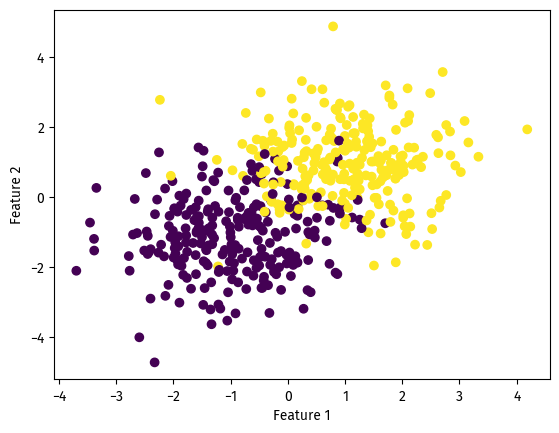

In [46]:
# Data
import numpy as np
from adam import LogisticRegression
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
from matplotlib import font_manager
font_manager.fontManager.addfont("C:\Windows\Fonts\FiraSans-Regular.ttf")
plt.rcParams["font.family"] = "Fira Sans"
np.seterr(all='ignore')
np.random.seed(283)

# make the data
p_features = 3
X, y = make_blobs(
    n_samples=500, n_features=p_features - 1, centers=[(-1, -1), (1, 1)]
)

fig = plt.scatter(X[:, 0], X[:, 1], c=y)
xlab = plt.xlabel("Feature 1")
ylab = plt.ylabel("Feature 2")


### Time

We first examine the runtime and number of epochs for optimization with Adam.

Visualization code adapted from [blog post instructions](https://middlebury-csci-0451.github.io/CSCI-0451/assignments/blog-posts/blog-post-optimization.html#illustration).

In [47]:
max_epochs = 100000
alpha = 0.001

LR_base = LogisticRegression()
LR_sg = LogisticRegression()
LR_sgm = LogisticRegression()
LR_adam = LogisticRegression()

In [48]:
%%timeit
LR_base.fit(X, y, alpha=alpha, max_epochs=max_epochs)

2.07 s ± 250 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
%%timeit
LR_sg.fit_stochastic(
    X, y,
    max_epochs=max_epochs,
    momentum=False,
    batch_size=10,
    alpha=alpha
)

1.82 s ± 93.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
%%timeit
LR_sgm.fit_stochastic(
    X, y,
    max_epochs=max_epochs,
    momentum=True,
    batch_size=10,
    alpha=alpha
)

1.81 s ± 69.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%%timeit
LR_adam.fit_adam(
    X, y,
    alpha=alpha,
    max_epochs=max_epochs
)

639 ms ± 76.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


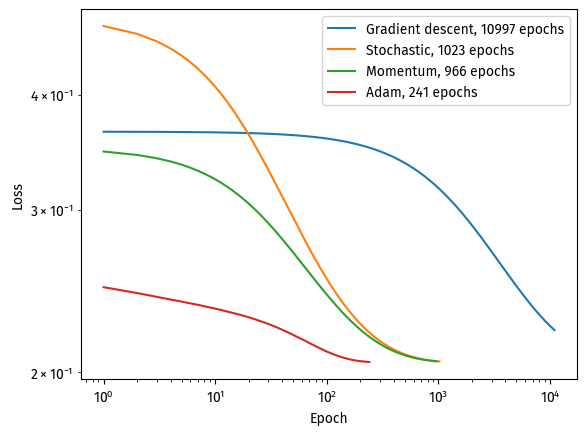

In [52]:
plt.plot(
    np.arange(len(LR_base.loss_history)) + 1,
    LR_base.loss_history,
    label=f"Gradient descent, {len(LR_base.loss_history)} epochs"
)

plt.plot(
    np.arange(len(LR_sg.loss_history)) + 1,
    LR_sg.loss_history,
    label=f"Stochastic, {len(LR_sg.loss_history)} epochs"
)

plt.plot(
    np.arange(len(LR_sgm.loss_history)) + 1,
    LR_sgm.loss_history,
    label=f"Momentum, {len(LR_sgm.loss_history)} epochs"
)

plt.plot(
    np.arange(len(LR_adam.loss_history)) + 1,
    LR_adam.loss_history,
    label=f"Adam, {len(LR_adam.loss_history)} epochs"
)

plt.loglog()

legend = plt.legend(loc="upper right")
xlab = plt.xlabel("Epoch")
ylab = plt.ylabel("Loss")


#### Epochs

We observe that Adam is the fastest, converging in only 241 epochs.

This is much faster than stochastic gradient descent, with or without the momentum method.
Both of these converged in around 1000 epochs.

Normal gradient descent is the slowest, failing to converge after 10000 epochs.

#### Wall time

Using the [`%%timeit`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit) magic command from IPython:

- Adam has the fastest runtime of 639 ms.
- Stocastic gradient descent, with or without momentum, took around 1.82 s.
- "Plain" gradient descent took 2.07 s, although 2.07 s is exactly 1 standard deviation away from 1.82 s.

### Learning rate
The [learning rate](https://developers.google.com/machine-learning/crash-course/reducing-loss/learning-rate) determines how much we move along the gradient.

When the learning rate is too large, gradient descent will exceed the optimal minimum;
when it is too small, gradient descent will take longer to reach the optimal minimum.

We loop our Adam implementation through multiple learning rates:

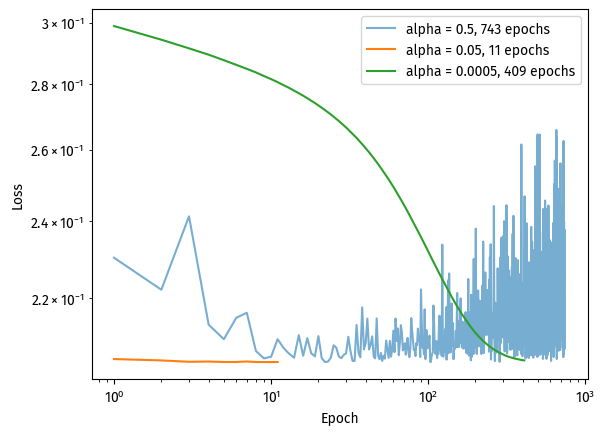

In [53]:
alphas = [0.5, 0.05, 0.0005]
max_epochs = 1000

for alpha in alphas:
    LR = LogisticRegression()
    LR.fit_adam(
        X, y,
        max_epochs=max_epochs,
        batch_size=10,
        alpha=alpha
    )

    num_steps = len(LR.loss_history)
    plt.plot(
        np.arange(num_steps) + 1, LR.loss_history,
        label=f"alpha = {alpha}, {num_steps} epochs",
        alpha=0.6 if alpha == 0.5 else 1
    )

plt.loglog()

legend = plt.legend()
xlab = plt.xlabel("Epoch")
ylab = plt.ylabel("Loss")

With three different learning rates, we can see a difference in how training loss progressed over time:

- Reasonably small, `alpha = 0.05`: loss decreased quickly, converging in only 11 iterations.
- Too small, `alpha = 0.0005`: loss decreased more smoothly but slowly, converging in 409 iterations.
- Too large, `alpha = 0.5`: loss jumped up and down frequently, converging in 743 iterations.

This shows that indeed, we want a reasonably small learning rate.
Small enough to converge, but not too small that converging becomes too slow.

### Batch size
We look at another hyperparameter, the batch size.

Because we look at each "batch" separately, the size of these batches, might determine the speed of gradient descent.

Using our reasonable learning rate of `alpha = 0.05`:

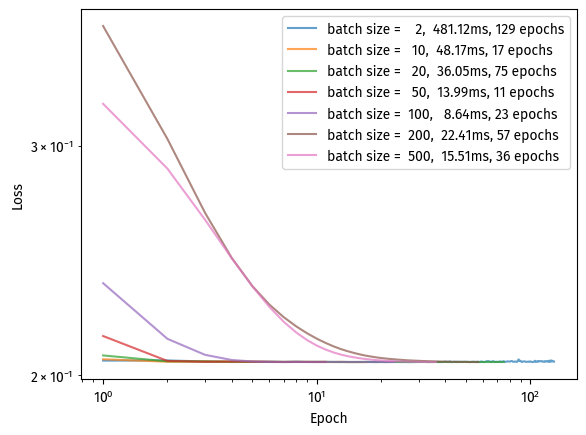

In [54]:
from time import perf_counter
batch_sizes = [2, 10, 20, 50, 100, 200, 500]
repeat = 5

for batch_size in batch_sizes:
    times = []
    for _ in range(repeat):
        LR = LogisticRegression()
        start = perf_counter() * 1000
        LR.fit_adam(
            X, y,
            max_epochs=1000,
            batch_size=batch_size,
            alpha=0.05
        )
        end = perf_counter() * 1000
        times.append(end - start)

    perf = sum(times) / len(times)

    num_steps = len(LR.loss_history)
    plt.plot(
        np.arange(num_steps) + 1, LR.loss_history,
        label=f"batch size = {batch_size:4}, {perf:> 6.2f}ms, {num_steps} epochs",
        alpha=0.7
    )

plt.loglog()

legend = plt.legend()
xlab = plt.xlabel("Epoch")
ylab = plt.ylabel("Loss")


Here, using otherwise identical hyperparameters, we observe that batch size does affect convergence speed and runtime.

A batch size of 2 yielded the most epochs and the longest runtime.

A batch size of 50 converged in the least epochs, although it is slightly slower than a batch size of 100 and 200, perhaps due to more calculations per loop.

Larger batch sizes took more epochs to converge, while maintaining around the same wall clock time.

In conclusion, a reasonable batch size (in this case, 100) strikes a nice balance between wall clock time and the number of epochs needed to converge.

## Digits
We load the [digits dataset](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) included with [`scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html).

Because we are predicting binary lables, we choose only the numbers `4` and `9`.
Then, we normalize the X and y labels.
Finally, we perform a train-test split.

In [171]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

digits = load_digits()
X = digits.data
y = digits.target
X = X[np.logical_or(y == 4, y == 9)]
y = y[np.logical_or(y == 4, y == 9)]

X = normalize(X, axis=0)
y = np.where(y == 4, 0, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=283
)

In [177]:
max_epochs = 1000
alpha = 2
batch_size = 5

LR_sgm = LogisticRegression()
LR_adam = LogisticRegression()

### Performance
Here, we only execute `%%timeit` once, because we will actually need the regression results later.

In [178]:
%%timeit -n1 -r1
LR_sgm.fit_stochastic(
    X_train, y_train,
    max_epochs=max_epochs,
    momentum=False,
    alpha=alpha,
    batch_size=batch_size
)

2.37 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [179]:
%%timeit -n1 -r1
LR_adam.fit_adam(
    X_train, y_train,
    alpha=alpha,
    max_epochs=max_epochs,
    batch_size=batch_size
)

502 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


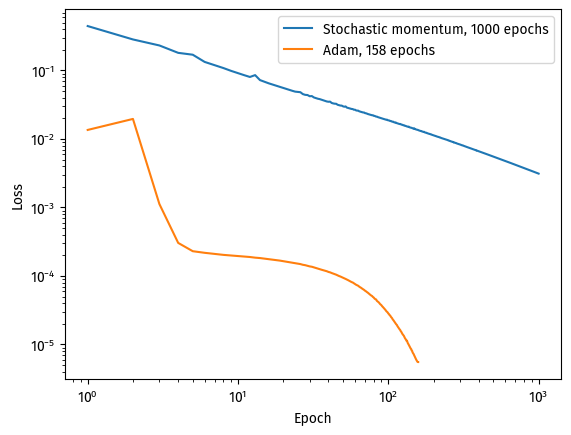

In [180]:
plt.plot(
    np.arange(len(LR_sgm.loss_history)) + 1,
    LR_sgm.loss_history,
    label=f"Stochastic momentum, {len(LR_sgm.loss_history)} epochs"
)

plt.plot(
    np.arange(len(LR_adam.loss_history)) + 1,
    LR_adam.loss_history,
    label=f"Adam, {len(LR_adam.loss_history)} epochs"
)

plt.loglog()

legend = plt.legend()
xlab = plt.xlabel("Epoch")
ylab = plt.ylabel("Loss")

With the same learning rate and batch size, stochastic-momentum did not converge in 1000 epochs.

On the other hand, Adam converged much faster than stochastic-momentum, and to a lower loss.

### Underflow
In our original implementation, Adam gave `nan` losses.

Since the losses dropped below $10^{-5}$, there was apparently some underflow.

One workaround is to treat `nan` loss as small enough, but this will only work with underflow and not other situations.

Another workaround is discussed in the blog post [How to Evaluate the Logistic Loss and not NaN trying](https://fa.bianp.net/blog/2019/evaluate_logistic/#sec3) by Fabian Pedregosa and Bart van Merriënboer, which builds upon ideas from [Martin Mächler](https://cran.r-project.org/web/packages/Rmpfr/vignettes/log1mexp-note.pdf).

In short, the new `log-sig` function now looks like this:

$$
\log(s(t)) = \begin{cases}
    t & t < -33.3\\
    t - \exp(t) & -33.3 \leq t \leq -18 \\
    -\text{log1p}(\exp(-t)) & -18 \leq t \leq 37 \\ 
    -\exp(-t) & 37 \leq t\\
\end{cases}
$$

The blog post continues to rewrite the gradient calculation step, which is not needed here at this point.

### Accuracy
We now test the accuracy of the two fitted models:

In [181]:
sgm_score = LR_sgm.score(X_test, y_test)
adam_score = LR_adam.score(X_test, y_test)

print(f"Momentum: {sgm_score:.4f}")
print(f"Adam    : {adam_score:.4f}")

from sklearn.metrics import confusion_matrix

pred = LR_adam.predict(X_test)


print("\nConfusion matrix for Adam: ")
print("   4  9")
print(confusion_matrix(y_test, pred))

Momentum: 0.9890
Adam    : 0.9890

Confusion matrix for Adam: 
   4  9
[[46  1]
 [ 0 44]]


Adam achieved an accuracy of 98.63%, with only 1 mis-classified number.

The momentum method, had the same accuracy, so also 1 mis-classified number.

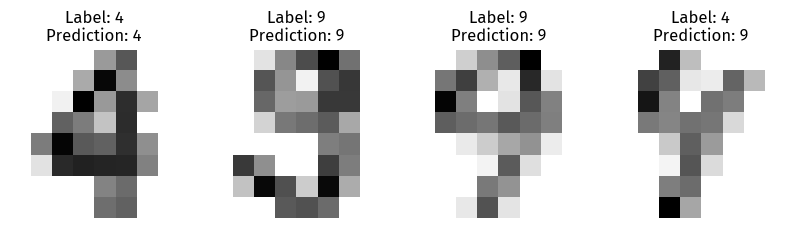

In [187]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label, prediction in zip(axes, X_test[87:], y_test[87:],  pred[87:]):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Label: {9 if label else 4}\nPrediction: {9 if prediction else 4}")

Visually, the misclassification looks ambiguous, to the extent that correctly classifying this might be a sign of overfitting.

## Breast Cancer
The next experiment is performed on the [Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)), which includes 569 samples and 30 dimensions.

Although this dataset has been extensively studied, it still carries more ethical implications than, say, handwritten digits.

For the targets, 1 gives a benign (noncancerous) diagnosis, and 0 gives a malignant (cancerous) diagnosis.

In [188]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

X = normalize(X, axis=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [189]:
max_epochs = 100000
alpha = 0.05
batch_size = 10

LR_sgm = LogisticRegression()
LR_adam = LogisticRegression()

We repeat the experiments in [the Digits section](#digits).

### Performance

In [190]:
%%timeit -n1 -r1
LR_sgm.fit_stochastic(
    X_train, y_train,
    max_epochs=max_epochs,
    momentum=False,
    alpha=alpha,
    batch_size=batch_size
)

33.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [191]:
%%timeit -n1 -r1
LR_adam.fit_adam(
    X_train, y_train,
    alpha=alpha,
    max_epochs=max_epochs,
    batch_size=batch_size
)

1.27 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


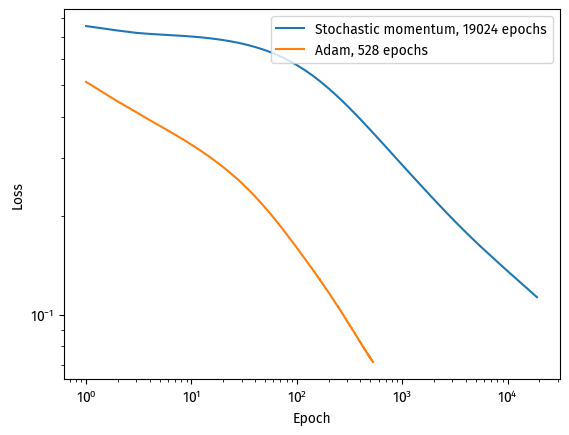

In [192]:
plt.plot(
    np.arange(len(LR_sgm.loss_history)) + 1,
    LR_sgm.loss_history,
    label=f"Stochastic momentum, {len(LR_sgm.loss_history)} epochs"
)

plt.plot(
    np.arange(len(LR_adam.loss_history)) + 1,
    LR_adam.loss_history,
    label=f"Adam, {len(LR_adam.loss_history)} epochs"
)

plt.loglog()

legend = plt.legend(loc="upper right")
xlab = plt.xlabel("Epoch")
ylab = plt.ylabel("Loss")

With the same learning rate and batch size, Adam converged much faster than stochastic-momentum, both in terms of epochs and wall clock time.

### Accuracy
We now test the accuracy of the two fitted models:

In [195]:
sgm_score = LR_sgm.score(X_test, y_test)
adam_score = LR_adam.score(X_test, y_test)

print(f"Momentum: {sgm_score:.4f}")
print(f"Adam    : {adam_score:.4f}")

from sklearn.metrics import confusion_matrix

pred = LR_sgm.predict(X_test)


print("\nConfusion matrix for Momentum: ")
print("   0  1")
print(confusion_matrix(y_test, pred))

pred = LR_adam.predict(X_test)


print("\nConfusion matrix for Adam: ")
print("   0  1")
print(confusion_matrix(y_test, pred))

Momentum: 0.9790
Adam    : 0.9860

Confusion matrix for Momentum: 
   0  1
[[52  2]
 [ 1 88]]

Confusion matrix for Adam: 
   0  1
[[53  1]
 [ 1 88]]


We can see that Adam performed slightly better than the momentum method, mis-classifying one less cancerous diagnosis as noncancerous.

This variation, however, might be the result of randomness instead of an actual accuracy difference.

## Conclusion

As we have seen, Adam is an efficient optimization on stochastic gradient descent, cutting both the number of epochs and the wall clock time.

Because these are initialized as zeroes, the authors corrects that bias by introducing $\hat{m_t}$ and $\hat{v_t}$.

Through interacting with a [visualization](https://emiliendupont.github.io/2018/01/24/optimization-visualization/), one can observe that Adam can achieve the global minima faster and more often than SGD, momentum, and RMSProp.

In implementing Adam, we also encountered underflow, which is an important aspect of applying mathematical models to a computer program.
It also highlights the importance of using existing frameworks, since these are often well-tested.

Adam itself is built upon [AdaGrad](https://jmlr.org/papers/v12/duchi11a.html) and [RMSProp](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf).
This highlights that work in the field is often built upon others' work.

### Effectiveness
The name "Adam" comes from "adaptive moment estimation", referring to both the mean $m_t$ (Line 7, "first moment") and variance $v_t$ (Line 8, "second moment").

As explained in Section 2, Adam's effectiveness can be partly explained by two aspects:

1. The learning rate decays exponentially, as suggested by $\alpha_t = \alpha \cdot \sqrt{1-\beta_2^t} / (1-\beta_1^t)$.
    This establishes a "trust region" so that $\alpha$ has the right scale.

2. The ratio of $m_t \cdot \sqrt{v_t}$ is a "signal-to-noise ratio", determining how much to move the weights vector.
    If the SNR is small, there is greater uncertainty in the weights, so the algorithm is more cautious.

These are combined in the more efficient algorithm proposed in section 2, which is essentially moving $\theta$ by the product of $\alpha_t$ and $m_t \cdot \sqrt{v_t}$.
